In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings, BlockDiagonals, Plots.PlotMeasures

In [2]:
dpi=1000;
l=1.5;

In [631]:
N = K = 2;
L = 3; #multiple antennas -> vector valued gammas
P = 0.7; 
σₕ = 1.0;
σₙ = σₕ/10;
ϵ = 0.2;
p = QuadTeamProblem(N, N * K * L * ones(Int64, N), L*ones(Int64, N), ComplexF64);
t = teamMMSEproblem(
	P,
	N,
	L,
	K,
	σₕ * ones(Float64, N),
	σₙ * ones(Float64, N),
	ϵ * ones(Float64, N)
);


In [632]:
S = 1000;
iters = 10;
Y_data, _, _ = generateTeamMMSEsamples(t, S);
_, Q_data, R_data = generateTeamMMSEsamples(t, Int(ceil(S/2)));

In [633]:
C1 = mean(Q_data[1, 1]);
C2 = mean(Q_data[2, 2]);
h1 = h2 = 0.5;
λ1 = λ2 = σₙ^2; #noise variance

K1(x, t) = matrixExponentialKernel([h1], [C1], [λ1], x, t);
K2(x, t) = matrixExponentialKernel([h2], [C2], [λ2], x, t);
kernels = [K1, K2];
λ = [λ1, λ2];


In [634]:
function reformatData(Y_data::Vector{<:Vector}, Q_data::Matrix{<:Vector}, R_Data::Vector{<:Vector})
    Y = [vcat(vec.(Y_data[i])...) for i in eachindex(Y_data)]
    R = [vcat(vec.(R_data[i])...) for i in eachindex(R_data)]
    Q   = [
        i == j ? vcat(Q_data[i, j]...) : BlockDiagonal(Q_data[i, j]) for
        i in axes(Q_data, 1), j in axes(Q_data, 2)
    ]
    return Y, Q, R
end

reformatData (generic function with 1 method)

In [635]:
function covariance(kernel::Function, X::AbstractVector, X_t::AbstractVector)
    G = [kernel(x, y) for x in X, y in X_t]
    return hvcat((size(G, 1)), G...)
end

covariance (generic function with 1 method)

In [636]:
function solverPreprocessing(
	Y::Vector{<:Vector},
	Q::Matrix{<:AbstractMatrix},
	R::Vector{<:Vector},
	λ::Vector{Float64},
	kernels::Vector{<:Function},
	L::Int,
	K::Int,
	N::Int,
	S::Int,
)
	m   = Int(ceil(S / 2))
	n   = L * N * K
	Y_o = [[Y[i][l:(l+n-1)] for l in 1:n:n*m] for i in eachindex(Y)]
	Y_p = [[Y[i][l:(l+n-1)] for l in m*n:n:(length(Y[i])-n)] for i in eachindex(Y)]
	G_o = [covariance(kernels[i], Y_o[i], Y_o[i]) for i in eachindex(Y_data)]
	G_p = [covariance(kernels[i], Y_o[i], Y_p[i]) for i in eachindex(Y_data)]
	C   = [cholesky(G_o[i] + λ[i] * I) for i in eachindex(G_o)]
	D   = [G_p[i] * (C[i] \ Q[i, i]) for i in axes(Q_data, 1)]
	Q_f = deepcopy(Q)
	for i in axes(Q_data, 1)
		Q_f[i, i] =
			BlockDiagonal([D[i][l:(l+L-1), :] for l in 1:L:size(D[1], 1)])
	end
	return G_o, G_p, C, Q_f
end


solverPreprocessing (generic function with 1 method)

In [637]:
function optimizedGaussSeidel(
	G_o::Vector{<:Matrix},
	G_p::Vector{<:Matrix},
	C::Vector,
	Q::Matrix{<:AbstractMatrix},
	R::Vector{<:Vector};
	iterations = 10,
)
	g = [[zeros(ComplexF64, size(G_p[1], 1))] for _ in eachindex(R)]
	for k in 1:iterations
		for i in eachindex(R)
			append!(
				g[i],
				[
					-Q[i, i] \ (
						G_p[i] * (
							C[i] \ (
								sum([
									Q[i, j] * g[j][end] for
									j in setdiff(eachindex(R), i)
								]) + R[i]
							)
						)
					),
				],
			)
		end
	end
	return g
end

optimizedGaussSeidel (generic function with 1 method)

In [638]:
@time Y, Q, R = reformatData(Y_data, Q_data, R_data);

  0.517104 seconds (587.10 k allocations: 30.336 MiB, 99.73% compilation time)


In [639]:
@time G_o, G_p, C, Q_f = solverPreprocessing(Y, Q, R, λ, kernels, L, K, N, S);

  2.464578 seconds (6.60 M allocations: 1.019 GiB, 13.19% gc time, 26.15% compilation time)


In [640]:
@time g = optimizedGaussSeidel(G_o, G_p, C, Q_f, R, iterations=iters);

  0.292169 seconds (222.49 k allocations: 21.416 MiB, 55.86% compilation time)


In [641]:
γ = vcat.(g...);
conv = norm.(diff(γ));


In [642]:
γ_f = [[v[l:l+L-1] for l in 1:L:length(v)] for v in γ];


In [643]:
variance = norm.(diff(cov.(γ_f)));
first_moment = norm.(diff(mean.(γ_f)));

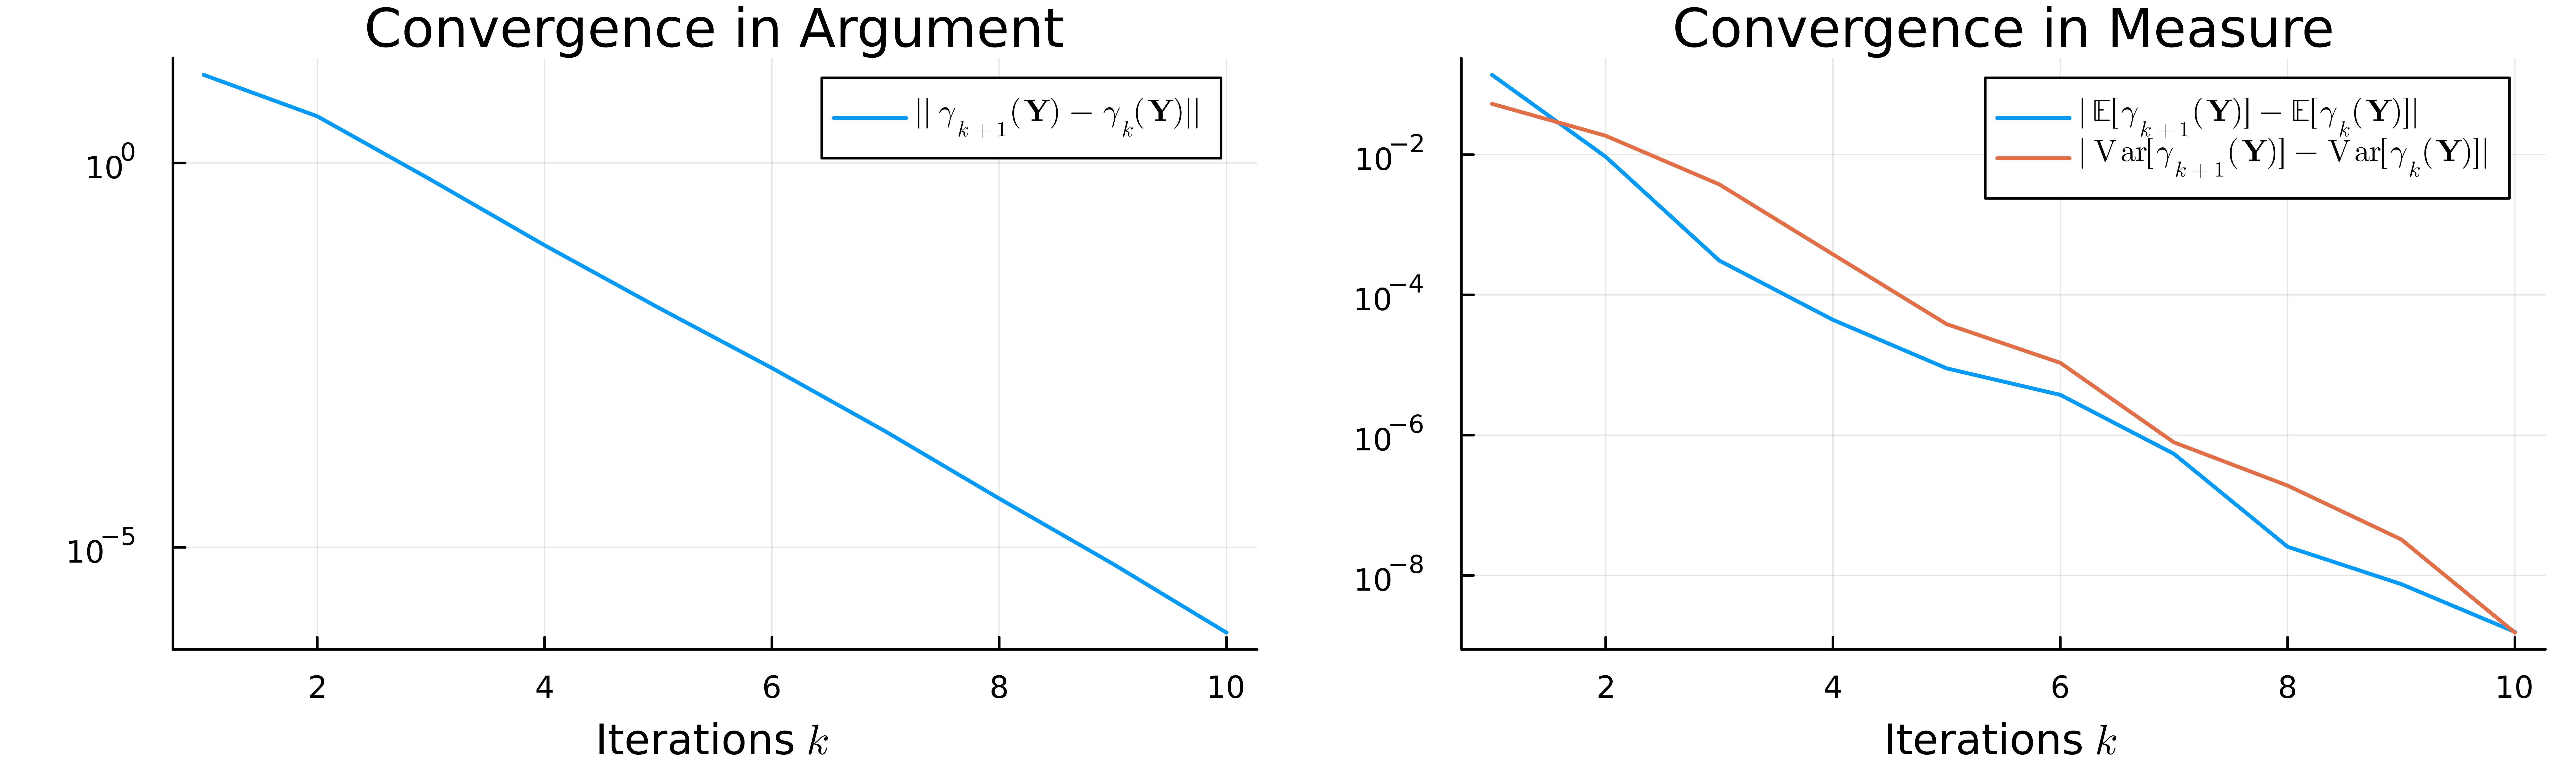

In [644]:
arg = plot(
	1:iters,
	conv,
	label = L"||\gamma_{k+1}(\mathbf{Y})-\gamma_k(\mathbf{Y})||",
	dpi = dpi,
	linewidth = l,
	yscale = :log10,
	title = "Convergence in Argument",
	xlabel = "Iterations " * L"k",
)
meas = plot(
	[variance, first_moment],
	yscale = :log10,
	label = [L"|\mathbb{E}[\gamma_{k+1}(\mathbf{Y})] - \mathbb{E}[\gamma_{k}(\mathbf{Y})]|" L"|\mathrm{Var}[\gamma_{k+1}(\mathbf{Y})] - \mathrm{Var}[\gamma_{k}(\mathbf{Y})]|"],
	dpi = dpi,
	linewidth = l,
	title = "Convergence in Measure",
	xlabel = "Iterations " * L"k",
)
plot(
	arg,
	meas,
	layout = (1, 2),
	size = (1000, 300),
	left_margin = 20px,
	bottom_margin = 20px,
)
